<a href="https://colab.research.google.com/github/woodRock/deep-learning-goodfellow/blob/main/chapter_7_regularization_for_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7 | Regularization for Deep Learning

References:
1. Hinton, G. E. (2012). Improving neural networks by preventing co-adaptation of feature detectors. arXiv preprint arXiv:1207.0580.
2. Srebro, N., & Shraibman, A. (2005, June). Rank, trace-norm and max-norm. In International conference on computational learning theory (pp. 545-560). Springer Berlin Heidelberg.
3. Sietsma, J., & Dow, R. J. (1991). Creating artificial neural networks that generalize. Neural networks, 4(1), 67-79.
4. Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The journal of machine learning research, 15(1), 1929-1958.
5. Jim, K. C., Giles, C. L., & Horne, B. G. (1996). An analysis of noise in recurrent neural networks: convergence and generalization. IEEE Transactions on neural networks, 7(6), 1424-1438.
6. Hochreiter, S., & Schmidhuber, J. (1994). Simplifying neural nets by discovering flat minima. Advances in neural information processing systems, 7.
7. Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
8. Belkin, M., & Niyogi, P. (2003). Laplacian eigenmaps for dimensionality reduction and data representation. Neural computation, 15(6), 1373-1396.
9. Lasserre, J. A., Bishop, C. M., & Minka, T. P. (2006, June). Principled hybrids of generative and discriminative models. In 2006 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'06) (Vol. 1, pp. 87-94). IEEE.
10. Hinton, G. E., & Salakhutdinov, R. R. (2007). Using deep belief nets to learn covariance kernels for Gaussian processes. Advances in neural information processing systems, 20.
11. Chapelle, O., Scholkopf, B., & Zien, A. (2006). Semi-supervised learning. 2006. Cambridge, Massachusettes: The MIT Press View Article, 2, 1.


We defined regularization as "any modification we make to a learning algorithm that is intended to reduce its generalization error but not its training error".

In [34]:
import numpy as np

class Tensor (object):

    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):

        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        if(id is None):
            self.id = np.random.randint(0,100000)
        else:
            self.id = id

        self.creators = creators
        self.creation_op = creation_op
        self.children = {}

        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True

    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):

            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad

            # grads must not have grads of their own
            assert grad.autograd == False

            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if (self.creators is not None and
               (self.all_children_grads_accounted_for() or
                grad_origin is None)):

                if (self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)

                if (self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if (self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)

                if (self.creation_op == "lt"):
                    self.creators[0].backward(Tensor(self.grad.data * (self.data > self.creators[1].data)), self)

                if (self.creation_op == "gt"):
                    self.creators[0].backward(Tensor(self.grad.data * (self.data < self.creators[1].data)), self)

                if (self.creation_op == "equal"):
                    self.creators[0].backward(Tensor(np.equal(self.data, self.creators[1].data)), self)

                if (self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)

                if (self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if ("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,self.creators[0].data.shape[dim]))

                if ("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))

                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())

                if (self.creation_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))

                if (self.creation_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))

                if (self.creation_op == "relu"):
                    self.creators[0].backward(self.grad * (self > 0))

                if (self.creation_op == "index_select"):
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))

                if (self.creation_op == "cross_entropy"):
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))

    @property
    def shape(self):
        return self.data.shape

    def __add__(self, other):
        if (self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if (self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)

    def __sub__(self, other):
        if (self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)

    def __mul__(self, other):
        if (self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)

    def __gt__(self, other):
        if isinstance(other, int):
            other = Tensor(other, autograd=self.autograd)
        if (self.autograd and other.autograd):
            return Tensor(self.data > other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="gt")
        return Tensor(self.data > other.data)

    def __lt__(self, other):
        if (self.autograd and other.autograd):
            return Tensor(self.data < other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="lt")
        return Tensor(self.data < other.data)

    def __eq__(self, other):
        if (self.autograd and other.autograd):
            return Tensor(self.data == other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="equal")
        return Tensor(self.data == other.data)

    def sum(self, dim):
        if (self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))

    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)

        if (self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)

    def transpose(self):
        if (self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")

        return Tensor(self.data.transpose())

    def mm(self, x):
        if (self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))

    def __repr__(self):
        return str(self.data.__repr__())

    def __str__(self):
        return str(self.data.__str__())

    def sigmoid(self):
        if (self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)), autograd=True, creators=[self], creation_op = "sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if (self.autograd):
            return Tensor(np.tanh(self.data), autograd=True, creators=[self], creation_op = "tanh")
        return Tensor(np.tanh(self.data))

    def relu(self):
        if (self.autograd):
            return Tensor(self.data * (self.data > 0), autograd=True, creators=[self], creation_op = "relu")
        return Tensor(self.data * (self.data > 0))

    def index_select(self, indices):
        if (self.autograd):
            new = Tensor(self.data[indices.data], autograd=True, creators=[self], creation_op = "index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])

    def cross_entropy(self, target_indices):
        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp, axis=len(self.data.shape)-1, keepdims=True)
        target_dist = target.data
        loss = -(np.log(softmax_output) * target_dist).sum(axis=1).mean()

        if (self.autograd):
            out = Tensor(loss, autograd=True, creators=[self], creation_op="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out

        return Tensor(loss)

class SGD(object):
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha

    def zero(self):
        for p in self.parameters:
            p.grad.data *= 0

    def step(self, zero=True):
        for p in self.parameters:
            p.data -= p.grad.data * self.alpha
            if (p.grad is None):
              print(f"Gradient is none for {p}, p.grad{p.grad}")
            if (zero):
                p.grad.data *= 0

class Layer(object):
    def __init__(self):
        self.parameters = list()

    def get_parameters(self):
        return self.parameters

class Linear(Layer):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        W = np.random.randn(n_inputs, n_outputs) * np.sqrt(2.0 / (n_inputs))
        self.weight = Tensor(W, autograd=True)
        self.bias = Tensor(np.zeros(n_outputs), autograd=True)

        self.parameters.append(self.weight)
        self.parameters.append(self.bias)

    def forward(self, input):
        return input.mm(self.weight) + self.bias.expand(0, len(input.data))

class Sequential(Layer):
    def __init__(self, layers=list(), training=True):
        super().__init__()
        self.layers = layers
        self.training = training

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, input):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                layer.training = self.training
            input = layer.forward(input)
        return input

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def get_parameters(self):
        params = list()
        for l in self.layers:
            params += l.get_parameters()
        return params

class Dropout(Layer):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
        self.mask = None

    def forward(self, input):
        # Only apply dropout when training.
        if self.training:
            # Multiply by 1 / (1 - p) to balance out the extra sensitivity.
            self.mask = np.random.binomial(1, 1-self.p, input.shape) / (1-self.p)
            return input * Tensor(self.mask, autograd=input.autograd)
        return input

    def backward(self, grad):
        return grad * self.mask


class MSELoss(Layer):

    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        return ((pred - target) * (pred - target)).sum(0)


class CrossEntropyLoss(object):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        return input.cross_entropy(target)

class Tanh(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input.tanh()

class Sigmoid(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input.sigmoid()

class Relu(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input.relu()


from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[0:1_000].reshape(1_000,28*28) / 255
X_test = X_test[0:1_000].reshape(1_000,28*28) / 255
y_train = y_train[0:1_000]
y_test = y_test[0:1_000]

# Onehot encoding
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

# Hyperparameters
alpha = 0.001
epochs = 100
batch_size = 100
input_dim = 784
hidden_size = 100
output_dim = 10

# Initialize the model
model = Sequential([
    Linear(input_dim,hidden_size),
    Tanh(),
    Dropout(p=0.5),
    Linear(hidden_size, hidden_size),
    Tanh(),
    Dropout(p=0.5),
    Linear(hidden_size, output_dim),
    Sigmoid()
])

criterion = CrossEntropyLoss()
optimizer = SGD(model.get_parameters(), alpha)

# Training loop
for j in range(epochs):
    correct_cnt = 0
    model.train()
    for i in range(int(len(X_train) / batch_size)):
        batch_start, batch_end = ((i * batch_size), ((i+1) * batch_size))
        input = Tensor(X_train[batch_start:batch_end], autograd=True)
        target = Tensor(y_train[batch_start:batch_end], autograd=True)

        # Forward pass
        prediction = model.forward(input)

        loss = criterion.forward(prediction, target)

        for k, p in enumerate(prediction.data):
            pred_label = p
            true_label = y_train[batch_start+k: batch_start+k+1]
            correct_cnt += int(np.argmax(pred_label.data) == np.argmax(true_label))

        # Back propgation
        loss.backward()
        # Update the weights0
        optimizer.step()

    training_accuracy = correct_cnt / float(len(y_train))

    if (j % 10 == 0 or j == epochs - 1):
        model.eval()
        test_correct_cnt = 0
        for i in range(int(len(X_test) / batch_size)):
          batch_start, batch_end = ((i * batch_size), ((i+1) * batch_size))
          input = Tensor(X_test[batch_start:batch_end], autograd=True)
          target = Tensor(y_test[batch_start:batch_end], autograd=True)

          # Forward pass
          prediction = model.forward(input)

          for k, p in enumerate(prediction.data):
              pred_label = p
              true_label = y_test[batch_start+k: batch_start+k+1]
              test_correct_cnt += int(np.argmax(pred_label.data) == np.argmax(true_label))

        test_accuracy = test_correct_cnt / float(len(y_test))
        print(f"I: {j} \t accuracy: {training_accuracy} \t test accuracy: {test_accuracy}")

I: 0 	 accuracy: 0.139 	 test accuracy: 0.225
I: 10 	 accuracy: 0.653 	 test accuracy: 0.7
I: 20 	 accuracy: 0.706 	 test accuracy: 0.756
I: 30 	 accuracy: 0.766 	 test accuracy: 0.765
I: 40 	 accuracy: 0.799 	 test accuracy: 0.778
I: 50 	 accuracy: 0.808 	 test accuracy: 0.787
I: 60 	 accuracy: 0.84 	 test accuracy: 0.81
I: 70 	 accuracy: 0.832 	 test accuracy: 0.816
I: 80 	 accuracy: 0.847 	 test accuracy: 0.816
I: 90 	 accuracy: 0.859 	 test accuracy: 0.818
I: 99 	 accuracy: 0.881 	 test accuracy: 0.824


 # $ L^2$ Regularization - Ridge regresssion

The $L^2$ parameters norm penalty common known as **weight decay**. This regularization strategy drives the weights closer to the origin, by adding a regularozation term $\Omega (\theta) = \frac{1}{2} || w ||^2_2$ to the objective function. In other academic communities, $L^2$ reguliarzation is also known as **ridge regression** or **Tikhonoz regularization**.

Such a model has the total objective function

$$
  \tilde{J} (w;X,y) = \frac{\alpha}{2} w^\top w + J(w;X,y)
$$

with the corresponding parameter gradient

$$
  \nabla_w \tilde{j} (W;X,y) = \alpha w + \nabla_w J(w;X,y)
$$

To take a single gradient step to update the weights, we perform this update

$$
  w \leftarrow w - \epsilon(\alpha w + \nabla_w J(w;X,y))
$$

Written another way, the update is

$$
  w \leftarrow (1 - \epsilon \alpha)w - \epsilon \nabla_w J(w;X,y)
$$

We can see that the addition of the weight decay term  has modified the learning rule to multiplicatively shrink the weight vector by a constant factor on each step, just before performing the usual gradient update. THis describes what happens in a single step

We will further simplify analysis by making a quadratic approximation to the objective function in the neighborhood of the value of weights tat obtian minimal unregularized training cost $w^* = argmin_w J(w)$. If the objective function is truly quadratic, as in the case of fitting a linear regression model with mean equared error, then the approximation is perfect. The approximation $\hat{J}$ is given by

$$
  \hat{J}(\theta) = J(w^*) + \frac{1}{2}(w - w^*)^\top H(w - w^*)
$$

where $H$ is the Hessian matrix of $J$ with respect to $w$ evaluated at $w^*$. There is no first-order term in the quadratic approximation, becuase $w^*$ is defined to be a minimum, where the gradient vanishes. Likewise, because $w^*$ is the location of a minimum of $J$, we can conclude $H$ is positive semidefinite.

Remember: Hessian is the Jacobian of the gradients. And positive semidefinite means the eigenvalues are zero or positive.

The minimum of $\hat{J}$ occurs where its gradient

$$
  \nabla_w \hat{J} (w) = H (w - w^*)
$$

is equal to $0$.

To studey the effect of weight decay, we modify the equation above by adding the weight decay gradient. We can now solve for the minimum of the regularized versio of $\hat{J}$. We use the variable $\tilde{w}$ to represent the location of the minimum.

$$
  \alpha \tilde{w} + H(\tilde{w} - w^*) = 0 \\
  (H + \alpha I) \tilde{w} = Hw^* \\
  \tilde{w} = (H + \alpha I)^{-1} Hw^*
$$

As $alpha$ appproaches $0$, the regularized solution $\tilde{w}$ approaches $w^*$. But what happens as $\alpha$ grows. Becuase $H$ is real and symmetric, we can decompose it into a diagonal matrix $\Lambda$ and an orthonormal basis of eigenvectors, $Q$, such that $H = Q\Lambda Q^\top$.

Applying the decomposition, we obtain

$$
  \tilde{w} = (Q\Lambda Q^\top + \alpha I)^{-1} Q\Lambda Q^\top w^* \\
  = [Q(\Lambda + \alpha I) Q^\top]^{-1} Q\Lambda Q^\top w^* \\
  = Q(\Lambda + \alpha I)^{-1} \Lambda Q^\top w^*
$$

We see that the effect of the weight decay is to recale $w^*$ along the axes defined by the eigenvectors of $H$. Specifically, the component $w^*$ that is aligned with the $i$th eigenvector of $J$ is recaled by a factor of $\frac{\lambda_i}{\lambda_i + \alpha}$

For linear regression the cost function is the sum of squared errors:

$$
  (Xw - y)^\top (Xw - y)
$$

When we add $L^2$ regularization, the objective function changes to

$$
  (Xw - y)^\top (Xw - y) + \frac{1}{2}\alpha w^\top w
$$

This changes the normal equations for the solution from

$$
  w = (X^\top X)^{-1} X^\top y
$$

to

$$
  w = (X^\top X + \alpha I)^{-1} X^\top y
$$

The matrix $X^\top X$ in the equation above is proportional to the covariance matrix $\frac{1}{m} X^\top X$. Using the $L^2$ regularization replaces this matrix with $(X^\top X + \alpha I)^{-1}$. The new matrix is the same as the original one, but with the addition of $\alpha$ to the diagonal. The diagonal entires of this matrix correspond to the variance of each input feature. We can see that $L^2$ regularization cuases the learning algorithm to percieve the input $X$ as having higher variance, which makes it shrink the weights on features whose covariance with the output target is low compared to this added variance.

In [3]:
class RidgeLoss(Layer):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = Tensor(alpha, autograd=True)  # Regularization strength

    def forward(self, pred, target, model):
        # Compute the Mean Squared Error (MSE)
        mse_loss = ((pred - target)*(pred - target)).sum(0)

        # Compute the Ridge (L2) regularization term
        ridge_loss = Tensor(0.0, autograd=True)
        for param in model.get_parameters():
            ridge_loss += Tensor((param.data ** 2).sum(), autograd=True)

        # Combine MSE loss and Ridge regularization
        total_loss = mse_loss + self.alpha * ridge_loss
        return total_loss

# Hyperparameters
input_dim = 784
output_dim = 10
hidden_size = 50
alpha = 0.01
epochs = 100
batch_size = 100
lambda_reg = 1

# Initialize the model
model = Sequential([
    Linear(input_dim, hidden_size),
    Tanh(),
    Linear(hidden_size, output_dim),
    Sigmoid()
])

criterion = RidgeLoss(lambda_reg)
optimizer = SGD(model.get_parameters(), alpha)

# Training loop
for epoch in range(epochs):
    total_loss = 0
    correct_cnt = 0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        input = Tensor(batch_X, autograd=True)
        target = Tensor(batch_y, autograd=True)

        # Forward pass
        prediction = model.forward(input)
        loss = criterion.forward(prediction, target, model)
        total_loss += loss.data

        for i in range(len(prediction.data)):
            pred_label = prediction.data[i]
            true_label = batch_y[i]
            correct_cnt += int(np.argmax(pred_label.data) == np.argmax(true_label))

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    accuracy = correct_cnt / float(len(y_train))
    avg_loss = total_loss / (len(X_train) / batch_size)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Accuracy: {accuracy}, Average Loss: {avg_loss}")

# Evaluation
model.eval()
X_test_tensor = Tensor(X_test, autograd=True)
y_pred = model.forward(X_test_tensor)
test_accuracy = 0
for i in range(len(y_pred.data)):
    pred_label = y_pred.data[i]
    true_label = y_test [i]
    test_accuracy += int(np.argmax(pred_label.data) == np.argmax(true_label))
test_accuracy = test_accuracy / float(len(y_test))
print(f"Test Accuracy: {test_accuracy}")
mse = ((y_pred.data - y_test) ** 2).mean()
print(f"Test MSE: {mse}")

Epoch 0, Accuracy: 0.25, Average Loss: [149.71756742 149.08735551 152.3935723  150.32780982 150.05081352
 150.02474318 150.09494829 153.94920526 149.86598981 151.86725038]
Epoch 10, Accuracy: 0.919, Average Loss: [193.88354811 194.24957714 195.02654405 194.73344478 194.59273575
 196.37221829 194.35825041 194.89958863 195.64647005 196.74727395]
Epoch 20, Accuracy: 0.963, Average Loss: [231.47724804 231.70994273 232.09964721 231.88604633 231.80330698
 232.47141013 231.71904414 231.99263437 232.52455902 232.59661729]
Epoch 30, Accuracy: 0.977, Average Loss: [259.90403021 260.08386242 260.39163168 260.22430623 260.12296806
 260.53462639 260.09404132 260.1714858  260.56063415 260.58461158]
Epoch 40, Accuracy: 0.981, Average Loss: [281.84691181 281.97550432 282.25172755 282.13307962 282.02763328
 282.33666308 281.97759867 281.98712104 282.38355531 282.3952318 ]
Epoch 50, Accuracy: 0.983, Average Loss: [298.96169537 299.08161983 299.26505712 299.21892016 299.10774325
 299.36231252 299.0802734

# $L^1$ Regularization - Lasso regression

While $L^2$ weight decay is the most common form of weight decay, there are other ways to penalize the size of model parameters. Another option is to use the $L^1$ regularization, otherwise known as **lasso regression**.

Formally, $L^1$ regularization on the model parameter $w$ is defined as

$$
  \Omega(\theta) = ||w||_1 = \sum_i |w_i|
$$

that is, as the sum of absolute values of the individual parameters.

As with $L^2$ weight decay, $L^1$ weight decay controls the strength of the regularization by scaling the penalty $\Omega$ using a positive hyperparameter $\alpha$. Thus, the regularized objective function $\tilde{J} (w;X,y)$ is given by

$$
  \tilde{J} (w;X,y) = \alpha ||w||_1 + J(w;X,y)
$$

with the corresponding gradient

$$
  \nabla_w \tilde{J} (w;X,y) = \alpha sign(w) + \nabla_w J(X,y;w)
$$

where $sign(w)$ is simply the sign of $w$ applied element-wise.

We can see that the regularization contribution to the gradient no longer scales linearly with each $w_i$; instead it is a constant factor with sign equal to $sign(w_i)$. One consequence of this form of gradient is that we will not necessarily see clean algebraic solutions to quadratic approximiations of $J(X,y;w)$ as we did for $L^2$ regularization.

Our simple linear model has a quadratic cost function that we can represent via its Taylor series. Alternatively, we could imagine that this is a truncated Taylor series approximating the cost function of a more sophisticated model. The gradient in this setting is given by

$$
  \nabla_w \hat{J}(w) = H(w - w^*)
$$

where, again, $H$ is a Hessian matrix of $J$ with respect to $w$ evaluated at $w^*$

Becuase the $L^1$ penalty does not admit clean algebraic expressions in the case of a fully general Hessian, we will also make the further simplifying assumption that the Hessian is diagonal, $H = diag([H_{1,1}, \cdots, H_{n,n}])$ where $H_{i,i} > 0$. This assumption holds if the data for the linear regression problem has been preprocessed to remove all correlation between input features, which is accomplished using PCA.

Our quadratic approximation of the $L^1$ regularizaed objective  function decomposes into a sum over the parameters.

$$
  \hat{J}(w;X,y) - J(w^*;x,y) + \sum_i [\frac{1}{2} H_{i,i}(w_i - w_i^*)^2 + \alpha |w_i|]
$$

The problem of minmizing the cost function has an analytical solution with the following form:

$$
  w_i = sign(w^*) max \{ |w_i| - \frac{\alpha}{H_{i,i}}, 0\}
$$

Consider the situation where $w_i^* > 0$ for all $i$. There are two possible outcomes:

1. The case where $w_i^* \le \frac{\alpha}{H_{i,i}}$. Here the optimal value of $w_i$ under the regularized objective is simply $w_i = 0$. This occurs because the contribution of $J(w;X,y)$ to the regularized objective $\hat{J}(w;X,y)$ is overwhelmed - in direction $i$ - by the $L^1$ regularization, which puhses the value of $w_i$ to zero.
2.  The case where $w_i^* > \frac{\alpha}{H_{i,i}}$. In this case, the regularization does not move the potimal value of $w_i$ to zero but instead just shifts it in the direction by a distance equal to $\frac{\alpha}{H_{i,i}}$

A similar process happens when $w^*_i < 0$, but with the $L^1$ penalty making $w_i$ less negative by $\frac{\alpha}{H_{i,i}}$, or 0.

In comparison to $L^2$ regularization, $L^1$ regularization results in a solution that is more **sparse**. Spartisity in this context refers to the fact that some parameters have an optimial value of zero. The sparsity of $L^1$ regularization is a qualitatively different behaviour than arises with $L^2$ regularization.

This equation gave the solution for $\tilde{w} for $L^2$ reguarlization:

$$
  \tilde{w} = (H + \alpha I)^{-1} Hw^*
$$

If we revisit that equation using the assumption of diagonal and positive semidefinite Hessian $H$ that we introduced for our analysis of $L^1$ regularization, we find that

$$
   \tilde{w} = \frac{H_{i,i}}{H_{i,i} + \alpha} w_i^*
$$

If $w_i$ is nonzero, then $\tilde{w}_i$ remains nonzero. This demonstrates that $L^2$ regularization does not cause the parameters to become spare, while $L^1$ regularization may do so for large enough $\alpha$.

$L^2$ regualirzation is equivalent to MAP Bayesian inference with a Gaussian prior on the weights. For $L^1$ regularization the penalty $ \alpha \Omega (w) = \alpha \sum_i |w_i| $ used to regularize the cost function is equivalent to the log-prior term that is maximized by MAP Bayesian inference when the prior is an isotropic Laplace distribution over $w \in \mathbb{R}^n$:

$$
  log p(w) = \sum_i \log Laplace(w_i;0,\frac{1}{a}) \\
  = -a ||w||_1 + n \log \alpha - n \log 2
$$

From the point of view of learning via maximization with respect to $w$, we can ignore $\log \alpha - \log 2$ terms because they do not depend on $w$.

Remember: An even simpler version is the **isotropic** Gaussian distribution, whose covariance matrix is a scalar times the identity matrix.

In [4]:
class LassoLoss(Layer):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = Tensor(alpha, autograd=True)  # Regularization strength

    def forward(self, pred, target, model):
        # Compute the Mean Squared Error (MSE)
        mse_loss = ((pred - target) * (pred - target)).sum(0)

        # Compute the Lasso (L1) regularization term
        lasso_loss = Tensor(0.0, autograd=True)
        for param in model.get_parameters():
            lasso_loss += Tensor(np.abs(param.data).sum(), autograd=True)

        # Combine MSE loss and Lasso regularization
        total_loss = mse_loss + self.alpha * lasso_loss
        return total_loss

# Hyperparameters
input_dim = 784
output_dim = 10
hidden_size = 50
alpha = 0.01
epochs = 100
batch_size = 100
lambda_reg = 1

# Initialize the model
model = Sequential([
    Linear(input_dim, hidden_size),
    Tanh(),
    Linear(hidden_size, output_dim),
    Sigmoid()
])

criterion = LassoLoss(lambda_reg)
optimizer = SGD(model.get_parameters(), alpha)

# Training loop
for epoch in range(epochs):
    total_loss = 0
    correct_cnt = 0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        input = Tensor(batch_X, autograd=True)
        target = Tensor(batch_y, autograd=True)

        # Forward pass
        prediction = model.forward(input)
        loss = criterion.forward(prediction, target, model)
        total_loss += loss.data

        for i in range(len(prediction.data)):
            pred_label = prediction.data[i]
            true_label = batch_y[i]
            correct_cnt += int(np.argmax(pred_label.data) == np.argmax(true_label))

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    accuracy = correct_cnt / float(len(y_train))
    avg_loss = total_loss / (len(X_train) / batch_size)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Accuracy: {accuracy}, Average Loss: {avg_loss}")

# Evaluation
model.eval()
X_test_tensor = Tensor(X_test, autograd=True)
y_pred = model.forward(X_test_tensor)
test_accuracy = 0
for i in range(len(y_pred.data)):
    pred_label = y_pred.data[i]
    true_label = y_test [i]
    test_accuracy += int(np.argmax(pred_label.data) == np.argmax(true_label))
test_accuracy = test_accuracy / float(len(y_test))
print(f"Test Accuracy: {test_accuracy}")
mse = ((y_pred.data - y_test) ** 2).mean()
print(f"Test MSE: {mse}")

Epoch 0, Accuracy: 0.231, Average Loss: [1765.29272919 1762.17268725 1765.84836012 1764.59209356 1766.72015149
 1763.30432291 1763.69789276 1764.68458601 1764.04235514 1766.00215663]
Epoch 10, Accuracy: 0.855, Average Loss: [1930.72373432 1930.98420915 1931.70332693 1931.64506782 1938.64813126
 1932.65013203 1930.99626491 1931.6226832  1932.54820268 1932.30302473]
Epoch 20, Accuracy: 0.965, Average Loss: [2042.38586084 2042.72704825 2043.05925517 2042.90365655 2043.09870438
 2043.23141454 2042.5856397  2042.86515532 2043.2967639  2043.33778975]
Epoch 30, Accuracy: 0.978, Average Loss: [2115.98823908 2116.33080299 2116.5416924  2116.24683449 2116.36435826
 2116.42619702 2116.17077511 2116.21021527 2116.5240825  2116.69586726]
Epoch 40, Accuracy: 0.984, Average Loss: [2167.82602883 2168.13440005 2168.2656277  2168.00059146 2168.05165033
 2168.11162262 2167.99533022 2167.94368637 2168.20029654 2168.42139014]
Epoch 50, Accuracy: 0.986, Average Loss: [2206.80665292 2207.10874666 2207.119321

# Norm Penalties as Constrained Optimization

Consider the cost function regularized by a parameter norm penatly:

$$
  \hat{J} (\theta,X,y) = J(\theta;X,y) + \alpha \Omega (\theta)
$$

If we wanted to constrain $\Omega(\theta)$ to be less than some constant $k$, we could construct a generalized Lagrange function

$$
  \mathcal{L} (\theta, \alpha; X, y) = J(\theta;X,y) + \alpha(\Omega(\theta) - k)
$$

The solution to the constrained problem is given by

$$
  \theta^* = argmin_\theta max_{a,a \ge 0} \mathcal{L}(\theta,\alpha)
$$

To gain some insight into the effect of this constraint, we can fix $\alpha^*$ and view the problem as just a function of $\theta$:

$$
  \theta^* = arg min_\theta \mathcal{L}(\theta,\alpha^*) = arg min_\theta J(\theta;X,y) + \alpha^* \Omega(\theta)
$$

This is exactly the same regularized training problem of minimizing $\tilde{J}$. We can thus think of a parameter norm penalty as imposing a constraint on the weights. If $\Omega$ is the $L^2$ norm, then the weights are constrained to lie in an $L^2$ ball. If $\Omega$ is the $L^1$ norm, the weights are constrained to lie in a region of limited $L^1$ norm.

Sometimes we may wish to use explicit constrains rather than penalties. We can modify algorithms such as stochastic gradient descent to take a step downhill on $J(\theta)$ then project $\theta$ back to the nearest point that satisfies $\Omega(\theta) < k$.

(Hinton (2012) recoomend a strategy intorduced by (Srebo and Shraibman 2005): constraining the norm of each column of the weight matrix of a neural network layer, rather than constraining the Frobenious nrom of the entire weight matrix. Constraining the norm of each column seperately prevents any one hidden unit from having very large weights. If we converted with constraint into a penalty in a Lagrange function, it would be similar to $L^2$ weight decay but with a seperate KKT multiplier for the weights of each hidden unit. Each of thse KKT mutlipliers would be dynamically updated seperately to make each hidden unit obey the constraint. In practise, column norm limitation is always implmeneted as an explicit constraint with reprojection.

# Regularization and Under-Constrained Problems

In some cases, regularization is necessary for machine learning problems to be properly defined. Many linear models in machine learning, including linear regression and PCA, depend on inverting a matrix $X^top X$. This is not possible when $X^\top X$ is singular. The matrix can be singular whenver the data-generating distribution turly has no variance in some direction, or when no variance is observed in some direction because there are fewer examples (rows of $X$) than input features (columns of $X$). In this case many forms of regularization correspond to inverting $X^top X + \alpha I$ instead. This regularized matrix is guaranteed to be invertible.

Linear problems have closed form solutions when the relevant matrix is inveritble. It is also possible for a problem with no closed form solution to be underdetermined. An example is logistic regression applied to a problem where the classes are linearly separable. If a weight vector $w$ is able to achieve perfect classification, then $2w$ will also achieve perfect classification and hihger likelihood. An iterative optmization procuded like stochastic gradient descent will continiously increase the magnitude of $w$ and, in theory, will never hault. In practise, a numerical implementation of gradient descent will eventually reach sufficiently large weights to cause numerical overflow, at which point its behaviour will depend on how the programmer has decided to handle values that are not real numbers.

Most forms of regularization are able to guaranteee convergence of iterative methods applied to undetermined problems. For example, weight decay will cuase gradient descent to quit increasing the magnitude of the weights when the slope of the likelihood is equal to the weight decay coefficient.

Recall that one definition of the psuedoinverse $X^+$ of matrix $X$ is

$$
   A^+ = \lim_{\alpha \to 0} (X^\top X + \alpha I)^{-1} X^\top
$$

We can now recognize this equation as performing linear regression with weight decay. Specifically, the equation above is the limit of

$$
  w = (X^\top X + \alpha I) X^\top y
$$

as the regularization coefficient shrinks to zero. We can thus interpret the pseudoinverse as stabilizing underdetermined problems using regularization.

# Dataset Augmentation

The best way to make a machine learning model generalize better is to train it on more data. Of course, in practise, the amount of data we have is limited. One way to get around this problem is to create fake data and add it to the training set. For some machine learning tasks it is reasonably straighforward to create new fake data.

Data augmentation has been a particularly effective technique for a specific classification problem: object recognition. Images are high dimensional and include an enourmous range of factors of varaition, many of which can easily be simulated. Operations like translating the training images a few pixels in each direction can often greatly improve generalization, even if the model has been designed to be partially translation invariant by using colution and poolting techniques. MAny other operations, such as rotating the image or scaling the image, have also provded quite effective.

Injecting noise in the input to a neural network (Sietsma & Dow 1991) can also be seen as a form of data augmentation.

Dropout (Srivastava 2014) can be seen as a process of creating new inputs by _multiplying_ by noise.

# Noise Robustness

Another wat that noise has been used in the service of regularizing models is by adding it to the weights. This technique has been used primarily in the context of recurrent neural networks (Jim 1996). This can be interpreted as stochastic implementation of Bayesian inference over the weights. The Bayesian treatment of learning would consider the model weights to be uncertrain and representable via a probability distribution that reflects this uncertainty. Adding noise to the weights is a practical, stochastic way to reflect this uncertainty.

Noise applied to teh weights can also be interpreted as equivalent to a more traditiondal form of regularization, enoucaging stability of the function to be learned. Consider the regerssion setting, where we with to train a function $\hat{y}(x)$ that maps a set of features $x$ to a scalar using least-squares cost function between the model predictions $\hat{y}(x)$ and the true values of $y$:

$$
  J = \mathbb{E}_{p(x,y)} [(\hat{y}(x) - y)^2]
$$

The training set consists of $m$ labeled examples $\{ (x^{(1), y^{(1)}}), \cdots, (x^{(n)}, y^{(n)}) \}$

We can now assume that with each input presentation we also include a random pertubation $\epsilon_w \sim \mathcal{N}(\epsilon,0,\eta I)$ of the network weights. Let us imagine that we have a standard $l$-layer MLP. We denote the perturbed model as $\hat{y}_{\epsilon_w}(x)$. Desipite the injection of noise, we are still interested in minimizing the squared error of the output of the network. The objective function thus becomes

$$
  \hat{J}_w  = \mathbb{E}_{p(x,y,\epsilon_w)} [(\hat{y}_{\epsilon_w}(x) - y)^2] \\
  = \mathbb{E}_{p(x,y,\epsilon_w)} [(\hat{y}^2_{\epsilon_w}(x) - 2y\hat{y}_{\epsilon_w} +  y^2)]
$$

For small $\eta$, the minimization of $J$ with added weight noise (with covariance $\eta I$) is equivalent to mininmization of $J$ with an additional regularization term: $\eta \mathbb{E}_{p(x,y)} [||\nabla w \hat{y}(x)||^2]$.

This form of regularization encourages the parameters to go to regions of the parameter space where small pertubations of the weights have a relatively small influence on the output. In other words, it pushes the model into regions where the model is relatively insensitive to small variations in the weights, finding points that are not merely minima, but minima surrounded by flat regions (Hochreiter 1994).

In the simplified case of linear regression (where, for instance $\hat{y}(x) = w^\top x + b$, this regularization term collapses into $\eta \mathbb{E}_{p(x)} [||x||^2]$, whicc is not a function of the parameters and therefore does not contribute to the gradient of $\tilde{J}_W$ with resepct to the model parameters.

# Injecting Noise at the Output Targets

Most datasets have some number of mistakes in the $y$ labels. It can be harmful to maximize $\log p(y|x)$ when $y$ is a mistake. One way to prevent this is to explicitly model the noise on the labels. For example we can assume that for some small constant $\epsilon$, the training set label $y$ is correct with probability $1 - \epsilon$, and otherwise any of the other possible labels might be correct. This assumption is easy to incorproate into the cost function analytically, rather than by explicitly drawing noise samples.

For example, **label smoothing** regularizes a model based on a softmax with $k$ output values by replacing the hard 0 and 1 classficiation targets with targets of $\frac{\epsilon}{k-1}$ and $1 - \epsilon$, respectively. The standard cross-entropy loss may then be used with these soft targets.

Maximum likelihood learning with a softmax classifier and hard targets may actually never converge - the softmax can never predict a probability of exactly 0 or exactly 1, so it will continue to learn larger and large weights, making more extreme predictions forever. It is possible to prevent this scenario using other regularization strategies like weight decay. Label smoothing has the advantage of preventing the pursuit of hard probabilities without discouraging correct classfication.

This strategy has been used since the 1980s, and continues to be featured prominently in modern neural networks (Szegedy 2016).

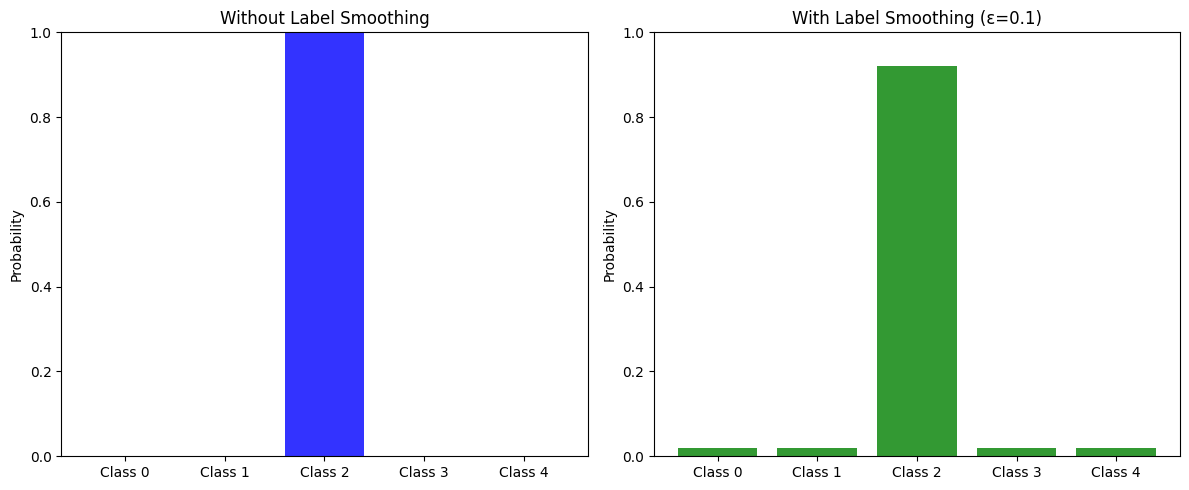

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def apply_label_smoothing(y, num_classes, smoothing=0.1):
    return (1 - smoothing) * y + smoothing / num_classes

# Set up the example
num_classes = 5
original_label = 2  # The correct class
smoothing = 0.1

# Create one-hot encoded label
y_one_hot = np.zeros(num_classes)
y_one_hot[original_label] = 1

# Apply label smoothing
y_smoothed = apply_label_smoothing(y_one_hot, num_classes, smoothing)

# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
x = np.arange(num_classes)

# Plot without label smoothing
ax1.bar(x, y_one_hot, align='center', alpha=0.8, color='blue')
ax1.set_xticks(x)
ax1.set_xticklabels([f'Class {i}' for i in range(num_classes)])
ax1.set_ylabel('Probability')
ax1.set_title('Without Label Smoothing')
ax1.set_ylim(0, 1)

# Plot with label smoothing
ax2.bar(x, y_smoothed, align='center', alpha=0.8, color='green')
ax2.set_xticks(x)
ax2.set_xticklabels([f'Class {i}' for i in range(num_classes)])
ax2.set_ylabel('Probability')
ax2.set_title(f'With Label Smoothing (ε={smoothing})')
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [6]:
class CrossEntropyLoss(object):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        if self.smoothing > 0:
            n_classes = input.shape[1]
            target_smooth = (1 - self.smoothing) * target.data + self.smoothing / n_classes
            target_smooth = Tensor(target_smooth, autograd=True)
        else:
            target_smooth = target

        temp = np.exp(input.data)
        softmax_output = temp / np.sum(temp, axis=len(input.data.shape)-1, keepdims=True)
        target_dist = target_smooth.data
        loss = -(np.log(softmax_output) * target_dist).sum(axis=1).mean()

        if (input.autograd):
            out = Tensor(loss, autograd=True, creators=[input], creation_op="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out

        return Tensor(loss)

# Hyperparameters
alpha = 0.001
epochs = 100
batch_size = 100
input_dim = 784
hidden_size = 100
output_dim = 10
label_smoothing = 0.1  # Add this line

# Initialize the model
model = Sequential([
    Linear(input_dim,hidden_size),
    Tanh(),
    Dropout(p=0.5),
    Linear(hidden_size, hidden_size),
    Tanh(),
    Dropout(p=0.5),
    Linear(hidden_size, output_dim),
    Sigmoid()
])

criterion = CrossEntropyLoss(smoothing=label_smoothing)  # Update this line
optimizer = SGD(model.get_parameters(), alpha)

# Training loop
for epoch in range(epochs):
    total_loss = 0
    correct_cnt = 0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        input = Tensor(batch_X, autograd=True)
        target = Tensor(batch_y, autograd=True)

        # Forward pass
        prediction = model.forward(input)
        loss = criterion.forward(prediction, target)
        total_loss += loss.data

        for i in range(len(prediction.data)):
            pred_label = prediction.data[i]
            true_label = batch_y[i]
            correct_cnt += int(np.argmax(pred_label.data) == np.argmax(true_label))

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    accuracy = correct_cnt / float(len(y_train))
    avg_loss = total_loss / (len(X_train) / batch_size)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Accuracy: {accuracy}, Average Loss: {avg_loss}")

# Evaluation
model.eval()
X_test_tensor = Tensor(X_test, autograd=True)
y_pred = model.forward(X_test_tensor)
test_accuracy = 0
for i in range(len(y_pred.data)):
    pred_label = y_pred.data[i]
    true_label = y_test [i]
    test_accuracy += int(np.argmax(pred_label.data) == np.argmax(true_label))
test_accuracy = test_accuracy / float(len(y_test))
print(f"Test Accuracy: {test_accuracy}")
mse = ((y_pred.data - y_test) ** 2).mean()
print(f"Test MSE: {mse}")

Epoch 0, Accuracy: 0.134, Average Loss: 2.314558066358867
Epoch 10, Accuracy: 0.573, Average Loss: 2.005551390240833
Epoch 20, Accuracy: 0.668, Average Loss: 1.9219434260185708
Epoch 30, Accuracy: 0.722, Average Loss: 1.8718763387242086
Epoch 40, Accuracy: 0.755, Average Loss: 1.8443464886217318
Epoch 50, Accuracy: 0.803, Average Loss: 1.8152896244813224
Epoch 60, Accuracy: 0.803, Average Loss: 1.801755278257923
Epoch 70, Accuracy: 0.828, Average Loss: 1.7731106488461001
Epoch 80, Accuracy: 0.827, Average Loss: 1.7694321364983838
Epoch 90, Accuracy: 0.847, Average Loss: 1.7545730920123461
Test Accuracy: 0.808
Test MSE: 0.066017195419862


# Semi-Supervised Learning

The the paradigm of semi-supervised learning, both unlabled examples from $P(x)$ and labeled examples from $P(x,y)$ are used to estimate $P(y|x)$ or predict $y$ from $x$.

In the context of deep learning, semi-supervised learning usually refers to learning a representation $h = f(x)$. The goal is to learn a representation that examples from the same class have similar representations. Unsupervised learning can provide useful clues for how to group examples in representation space. Examples that cluster tightly in the input space should be mapped to similar representations. A linear classifier in the new space may achive better generalization in many cases (Belkin & Niyogi 2003). A long standing variant of this approach is the application of principal components analysis as a preprocessing step before applying a classifier (on the projected data).

Instead of having separate unsupervised and supervised components in the model, one can construct models in which a generative model of either $P(x)$ or $P(x,y)$ shares parameters with a discriminative model of $P(y|x)$. One can then trade off the supvervised criterion $- \log P(x)$ or $ - \log P(x,y)$. The generative criterion then expresses a particulary form of prior belief about the solution to the supervised learning problem, namely that structure of $P(X)$ is connected to the structure of $P(y|x)$ in a way that is captured by shared parametrization. By controlling how much of the generative crition is included in the total criterion, one can find a better trade-off than with a purely generative or purely discriminative training criterion (Lasserre 2006).

(Salakhutdinov & Hinton 2007) describe a method for learning the kernel function of a kerneal machine used for gression, in which the usage of unlabeled examples for modelling $P(x)$ imrpoves $P(y|x)$ quite significantly.

See (Chapelle 2006) for more information about semi-supervised learning.

Epoch [1/50], Loss: 131.5579
Epoch [6/50], Loss: 58.7837
Epoch [11/50], Loss: 54.3455
Epoch [16/50], Loss: 45.9221
Epoch [21/50], Loss: 45.3605
Epoch [26/50], Loss: 42.2263
Epoch [31/50], Loss: 40.5929
Epoch [36/50], Loss: 43.3394
Epoch [41/50], Loss: 42.0246
Epoch [46/50], Loss: 38.6406


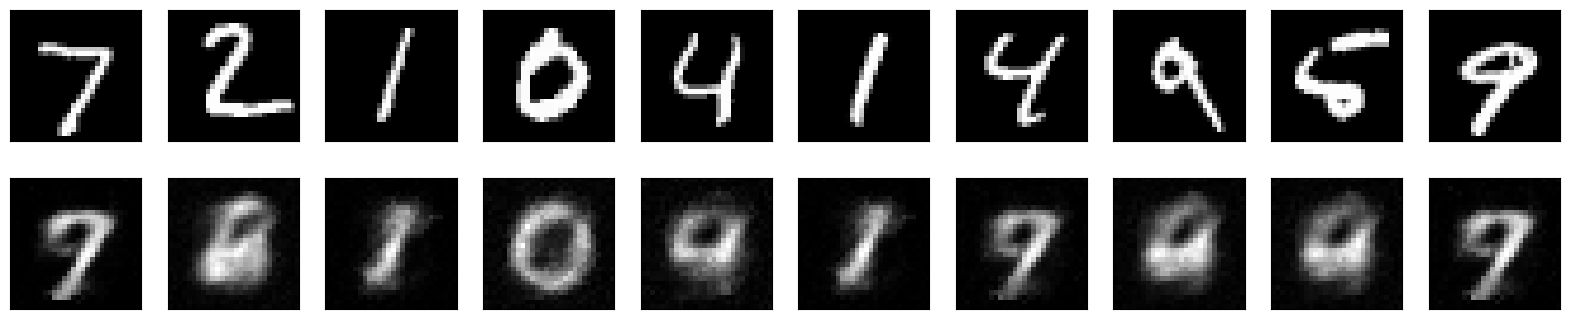

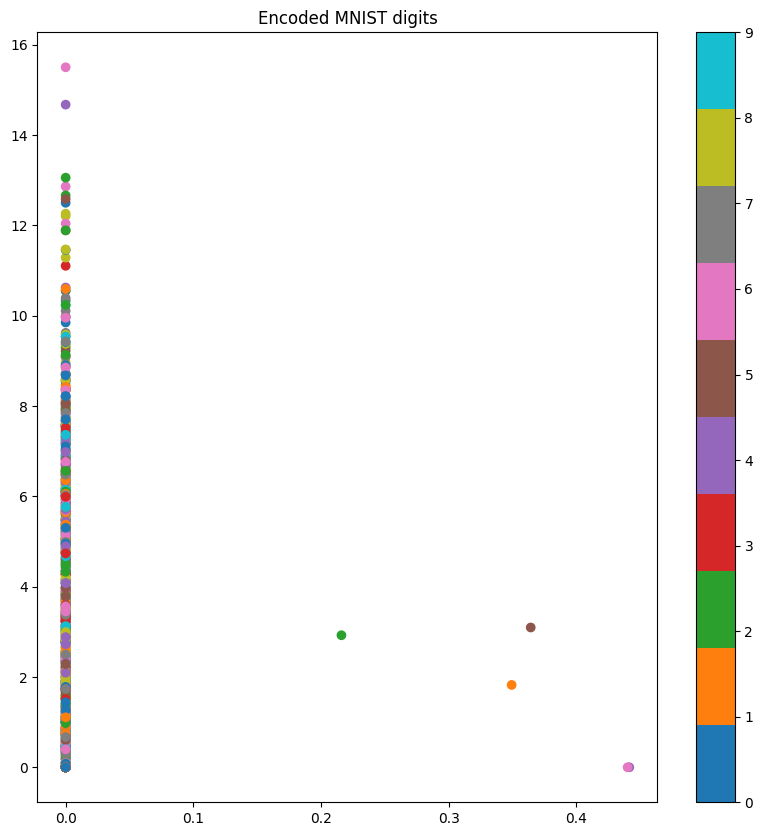

In [37]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess MNIST data
(X_train, y_test), (X_test, y_train) = mnist.load_data()
y_train = y_train[0:1_000]
y_test = y_test[0:1_000]
X_train = X_train[0:1_000].reshape(1_000, 28*28) / 255.0
X_test = X_test[0:1_000].reshape(1_000, 28*28) / 255.0

# Hyperparameters
input_dim = 784
encoding_dim = 128
alpha = 0.001
epochs = 50
batch_size = 256

# Define the autoencoder model
class Autoencoder(Sequential):
    def __init__(self, input_dim, encoding_dim):
        super().__init__()
        self.add(Linear(input_dim, encoding_dim))
        self.add(Relu())
        self.add(Linear(encoding_dim, input_dim))
        self.add(Sigmoid())

# Initialize the model
model = Autoencoder(input_dim, encoding_dim)

# Define loss and optimizer
criterion = MSELoss()
optimizer = SGD(model.get_parameters(), alpha)

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch = X_train[i:i+batch_size]
        input_tensor = Tensor(batch, autograd=True)

        # Forward pass
        output = model.forward(input_tensor)

        # Compute loss
        loss = criterion.forward(output, input_tensor)
        total_loss += loss.data.sum()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    # Print progress
    if epoch % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(X_train):.4f}")

# Function to visualize reconstructed digits
def visualize_reconstruction(model, data):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        input_tensor = Tensor(data[i:i+1], autograd=True)
        output = model.forward(input_tensor)
        plt.imshow(output.data.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Visualize some reconstructed digits
visualize_reconstruction(model, X_test[:10])

# Function to get encoded representations
def get_encoded_representations(model, data):
    encoded = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        input_tensor = Tensor(batch, autograd=True)
        # Get the output of the encoder (first two layers)
        encoded_batch = model.layers[1].forward(model.layers[0].forward(input_tensor))
        encoded.append(encoded_batch.data)
    return np.vstack(encoded)

# Get encoded representations of test data
encoded_data = get_encoded_representations(model, X_test)

# Visualize encoded representations (first two dimensions)
plt.figure(figsize=(10, 10))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=y_test, cmap='tab10')
plt.colorbar()
plt.title('Encoded MNIST digits')
plt.show()

# Multi-task Learning

Multitask learning is a way to improve generalization by pooling the examples (which can be seen as soft constraints imposed on the parameters) arising out of several tasks. In the same way that additiondal training examples put more pressure on the paremters of the model towards values that generalize well, when part of a model is shared across tasks, that part of the model is more constrained toward good values (assuming the sharing is justified), often yielding better generalization.

The figure below illustrates a very common form of multitask learning, in which different supversied tasks (predicting $y^{(I)}$ given $x$) share the saem input $x$, as well as some intermediate-level representation $h^{(shared)}$, capturing a common pool of factors. The model can be generally divinded into two kinds of parts and associated parameters.

1. Task-specific parameters (which only benefit from the examples of thier task to achieve good generalization). These are the right-most layers of the network below.

2. Generic parameters, shared across all tasks (which benefit from the pooled data of all tasks). These are the left-most layers of the network below.

In deep learning we make the following assumption:

  > Amoung the factors that explain the variations oversved in the data associated with different tasks, some are shared across two or more tasks.

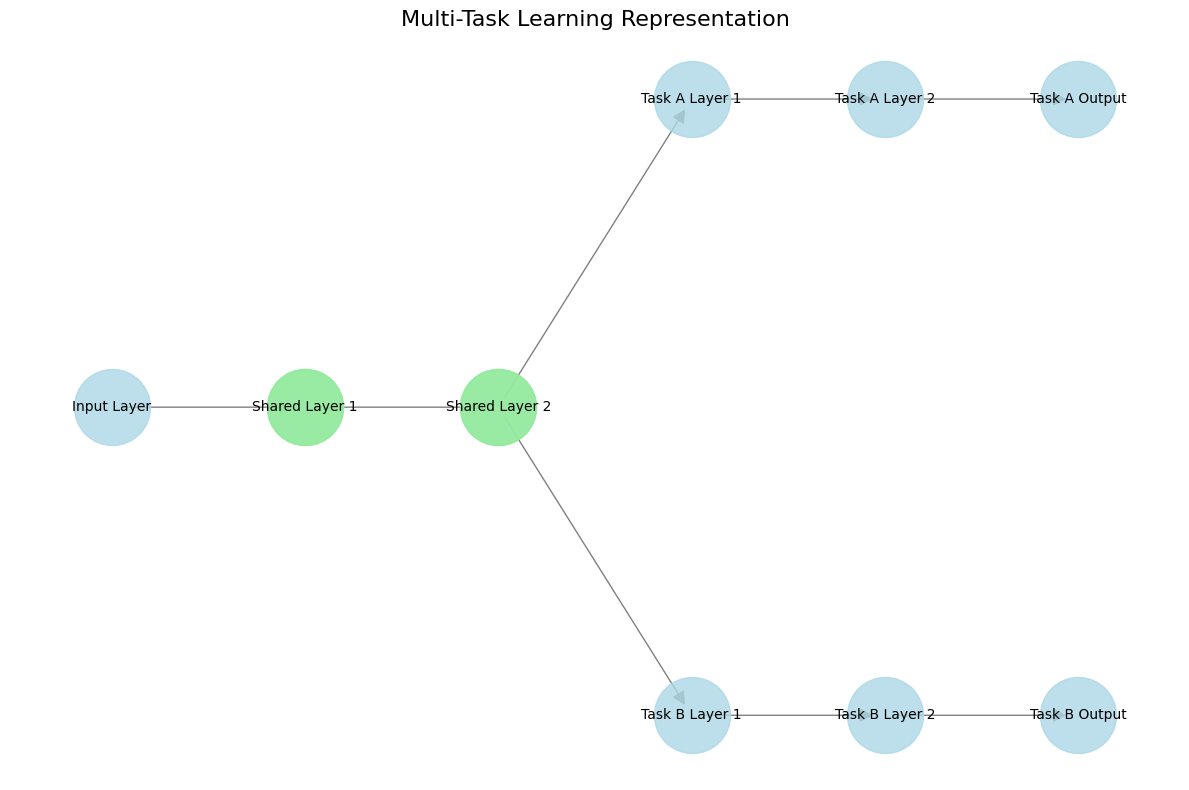

In [38]:
import matplotlib.pyplot as plt
import networkx as nx

def create_multi_task_graph():
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes
    G.add_node("Input Layer", pos=(0, 0))
    G.add_node("Shared Layer 1", pos=(1, 0))
    G.add_node("Shared Layer 2", pos=(2, 0))
    G.add_node("Task A Layer 1", pos=(3, 1))
    G.add_node("Task A Layer 2", pos=(4, 1))
    G.add_node("Task A Output", pos=(5, 1))
    G.add_node("Task B Layer 1", pos=(3, -1))
    G.add_node("Task B Layer 2", pos=(4, -1))
    G.add_node("Task B Output", pos=(5, -1))

    # Add edges
    edges = [
        ("Input Layer", "Shared Layer 1"),
        ("Shared Layer 1", "Shared Layer 2"),
        ("Shared Layer 2", "Task A Layer 1"),
        ("Shared Layer 2", "Task B Layer 1"),
        ("Task A Layer 1", "Task A Layer 2"),
        ("Task A Layer 2", "Task A Output"),
        ("Task B Layer 1", "Task B Layer 2"),
        ("Task B Layer 2", "Task B Output")
    ]
    G.add_edges_from(edges)

    return G

def plot_multi_task_graph(G):
    plt.figure(figsize=(12, 8))
    pos = nx.get_node_attributes(G, 'pos')

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=3000, alpha=0.8)
    nx.draw_networkx_nodes(G, pos, nodelist=["Shared Layer 1", "Shared Layer 2"],
                           node_color='lightgreen', node_size=3000, alpha=0.8)

    # Draw the edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)

    # Add labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    # Add title and adjust layout
    plt.title("Multi-Task Learning Representation", fontsize=16)
    plt.axis('off')
    plt.tight_layout()

    # Show the plot
    plt.show()

# Create and plot the graph
G = create_multi_task_graph()
plot_multi_task_graph(G)